# Cell type annotation with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a cell type annotation analysis with decoupler

# Set-up

In [1]:
# Global Imports
import os
import sys
import yaml
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/opt/igvf-ucsd/single_cell_utilities")
from utils import make_dirs

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def 

In [51]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"

# Inputs
platinum_dir = "/cellar/users/aklie/data/backup/beta_cell_networks/platinum"
in_date = "25Aug23"
in_dir = os.path.join(platinum_dir, dataset_name, in_date, "scRNA")

# Outputs
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome"
out_date = "09Aug23"
out_analysis = "cell_type_annotation"
out_dir = os.path.join(results_dir, out_date, out_analysis)
make_dirs(out_dir)

# Method params
annotation_resource = "PanglaoDB"
normalize_data = True
method = "ora"

In [54]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_date": out_date,
    "out_analysis": out_analysis,
    "out_dir": out_dir,
}
decoupler_params = {
    "annotation_resource": annotation_resource,
    "normalize_data": normalize_data,
    "method": method,
}
version_params = {
    "Python": sys.version[:5],
    "scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "run": decoupler_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "cell_type_annotation_params.yaml")):
    with open(os.path.join(out_dir, "cell_type_annotation_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

params.yaml already exists, will not overwrite


# Load data

In [17]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
adata = sc.read_10x_mtx(in_dir, cache=True)

In [18]:
# Metadata to add, may or may not be necessary depending on the adata
metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0)

/tmp/ipykernel_325459/489891427.py:2: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0)


In [19]:
# Add metadata to adata
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

In [20]:
# Print all the dim reduction files
reduce_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/barcode_metadata/igvf_sc-islet_10X-Multiome/10Aug23/reductions"
reductions = os.listdir(reduce_dir)
reductions

['sct.harmony.tsv',
 'lsi.tsv',
 'harmony.tsv',
 'pca.tsv',
 'atac.harmony.tsv',
 'umap.wnn.tsv']

In [21]:
# Add all the reduction files
reduce_names = []
for reduction in reductions:
    reduction_mat = pd.read_csv(os.path.join(reduce_dir, reduction), index_col=0, sep="\t")
    reduction = reduction.split(".tsv")[0].replace(".", "_")
    reduce_name = f"Seurat_{reduction}"
    adata.obsm[reduce_name] = reduction_mat.values
    reduce_names.append(reduce_name)
adata.obsm

AxisArrays with keys: Seurat_sct_harmony, Seurat_lsi, Seurat_harmony, Seurat_pca, Seurat_atac_harmony, Seurat_umap_wnn

In [22]:
# Clean up
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("category")
#adata.obs["time_point"] = adata.obs["time_point"].astype("category")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


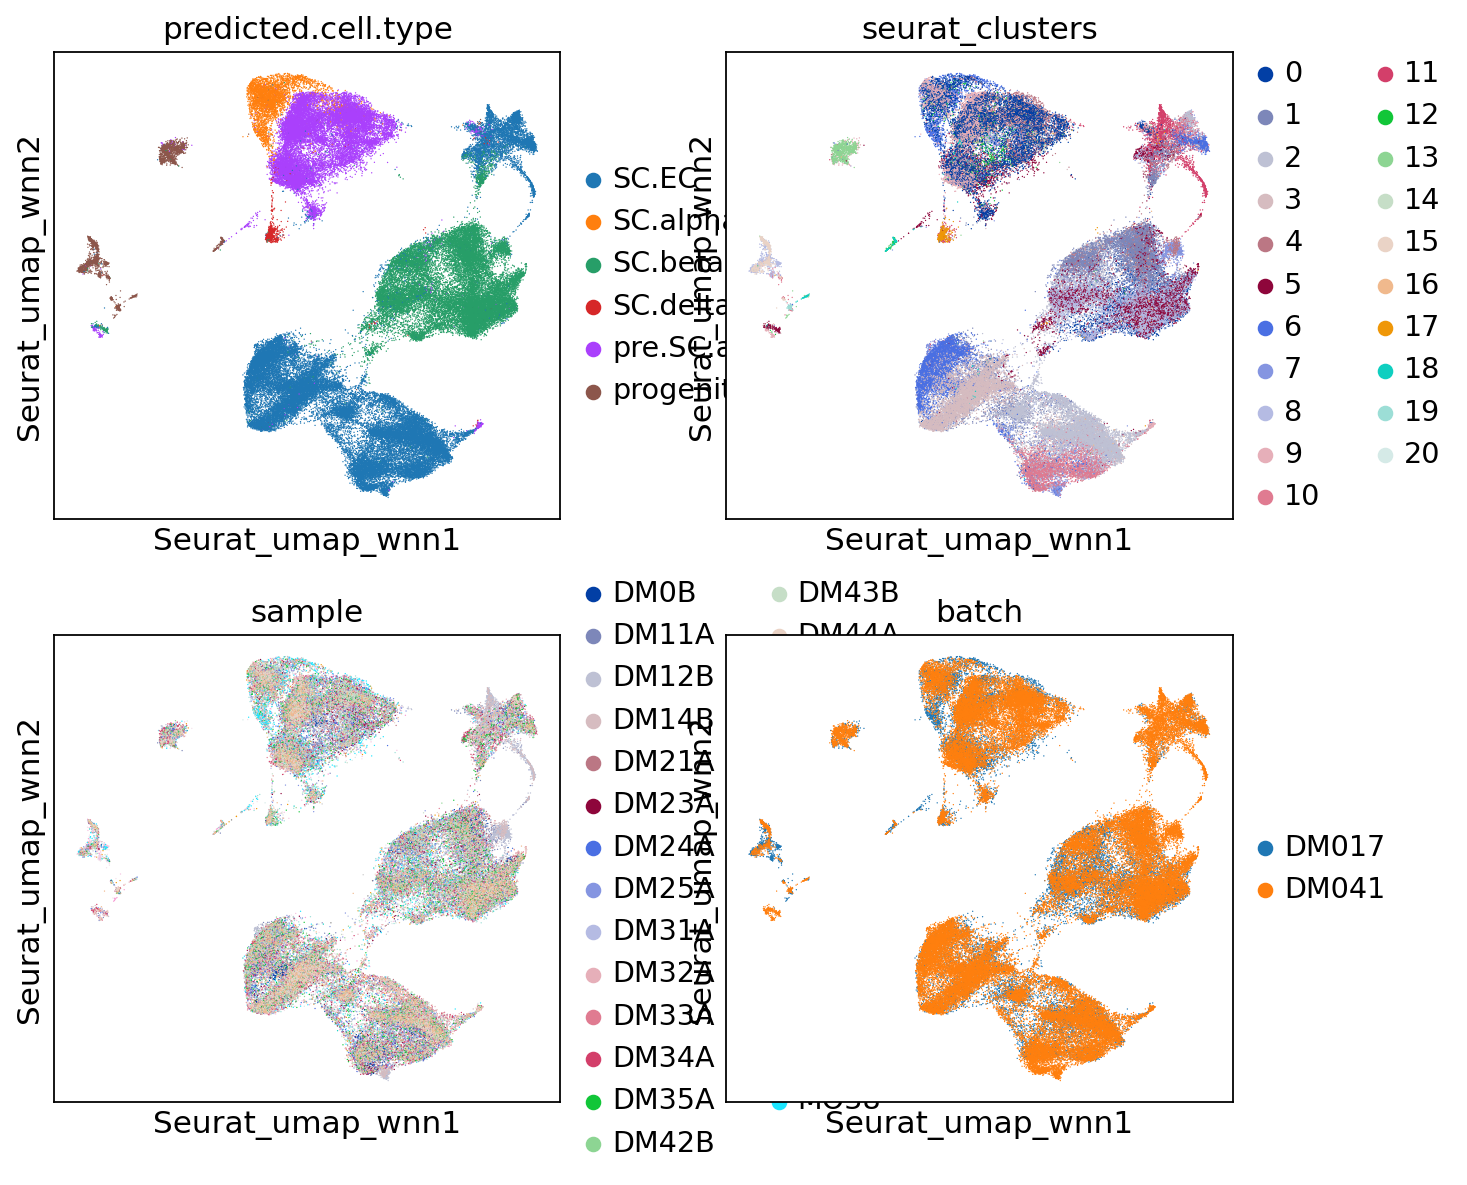

In [23]:
# Check the adata object
sc.pl.embedding(adata, basis='Seurat_umap_wnn', color=['predicted.cell.type', 'seurat_clusters', 'sample', 'batch'], ncols=2)

In [27]:
adata.X[:10, :10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Marker genes

In [55]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [56]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True') & (markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [57]:
# Save the markers that were actually used
markers.to_csv(os.path.join(out_dir, "markers_used.tsv"), sep="\t")

# Preprocess data

In [58]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [31]:
if normalize_data:
    # Normalize the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Store this is raw
    adata.raw = adata

# Run enrichment for markers

In [32]:
# Run ORA on top 5% of genes in each cell
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    use_raw=True,
    verbose=True
)

2820 features of mat are empty, they will be removed.
Running ora on mat with 83289 samples and 33781 targets for 151 sources.


100%|██████████| 83289/83289 [04:37<00:00, 300.55it/s]


In [33]:
# Check the results
adata.obsm['ora_estimate'].head()

source,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway epithelial cells,Airway goblet cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,Astrocytes,...,T regulatory cells,Tanycytes,Taste receptor cells,Thymocytes,Trichocytes,Trigeminal neurons,Trophoblast cells,Trophoblast progenitor cells,Tuft cells,Urothelial cells
MO1_AAACAGCCAGCAATAA-1,-0.0,-0.0,0.030359,0.295346,-0.000000,-0.0,1.704855,-0.0,0.231744,0.225358,...,0.184789,-0.000000,0.089754,0.267652,-0.0,-0.0,-0.000000,-0.0,0.115892,-0.0
MO1_AAACCAACAACCGCCA-1,-0.0,-0.0,0.003301,-0.000000,-0.000000,-0.0,0.891145,-0.0,-0.000000,0.013325,...,0.184789,-0.000000,0.089754,-0.000000,-0.0,-0.0,-0.000000,-0.0,0.115892,-0.0
MO1_AAACCGCGTATTGTGG-1,-0.0,-0.0,0.030359,0.295346,0.526454,-0.0,4.703695,-0.0,0.231744,0.225358,...,-0.000000,0.247484,0.671241,0.073894,-0.0,-0.0,-0.000000,-0.0,0.026487,-0.0
MO1_AAACGCGCAAGCCACT-1,-0.0,-0.0,0.066125,-0.000000,-0.000000,-0.0,0.891145,-0.0,-0.000000,0.046474,...,-0.000000,0.247484,0.089754,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0
MO1_AAACGCGCAGTTATCG-1,-0.0,-0.0,0.011458,-0.000000,-0.000000,-0.0,2.200193,-0.0,-0.000000,0.001978,...,-0.000000,0.067133,0.671241,0.073894,-0.0,-0.0,0.447441,-0.0,0.115892,-0.0


# Vizualize the results on the dimensionality reduction

In [34]:
# Basically just pulls out the above obsm into a new AnnDatas.X and copies the rest of it
acts = dc.get_acts(adata, obsm_key='ora_estimate')

In [35]:
# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [36]:
# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 83289 × 151
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score'
    var: 'mean', 'std'
    uns: 'predicted.cell.type_colors', 'seurat_clusters_colors', 'sample_colors', 'batch_colors', 'log1p'
    obsm: 'Seurat_sct_harmony', 'Seurat_lsi', 'Seurat_harmony', 'Seurat_pca', 'Seurat_atac_harmony', 'Seurat_umap_wnn', 'ora_estimate', 'ora_pvals'

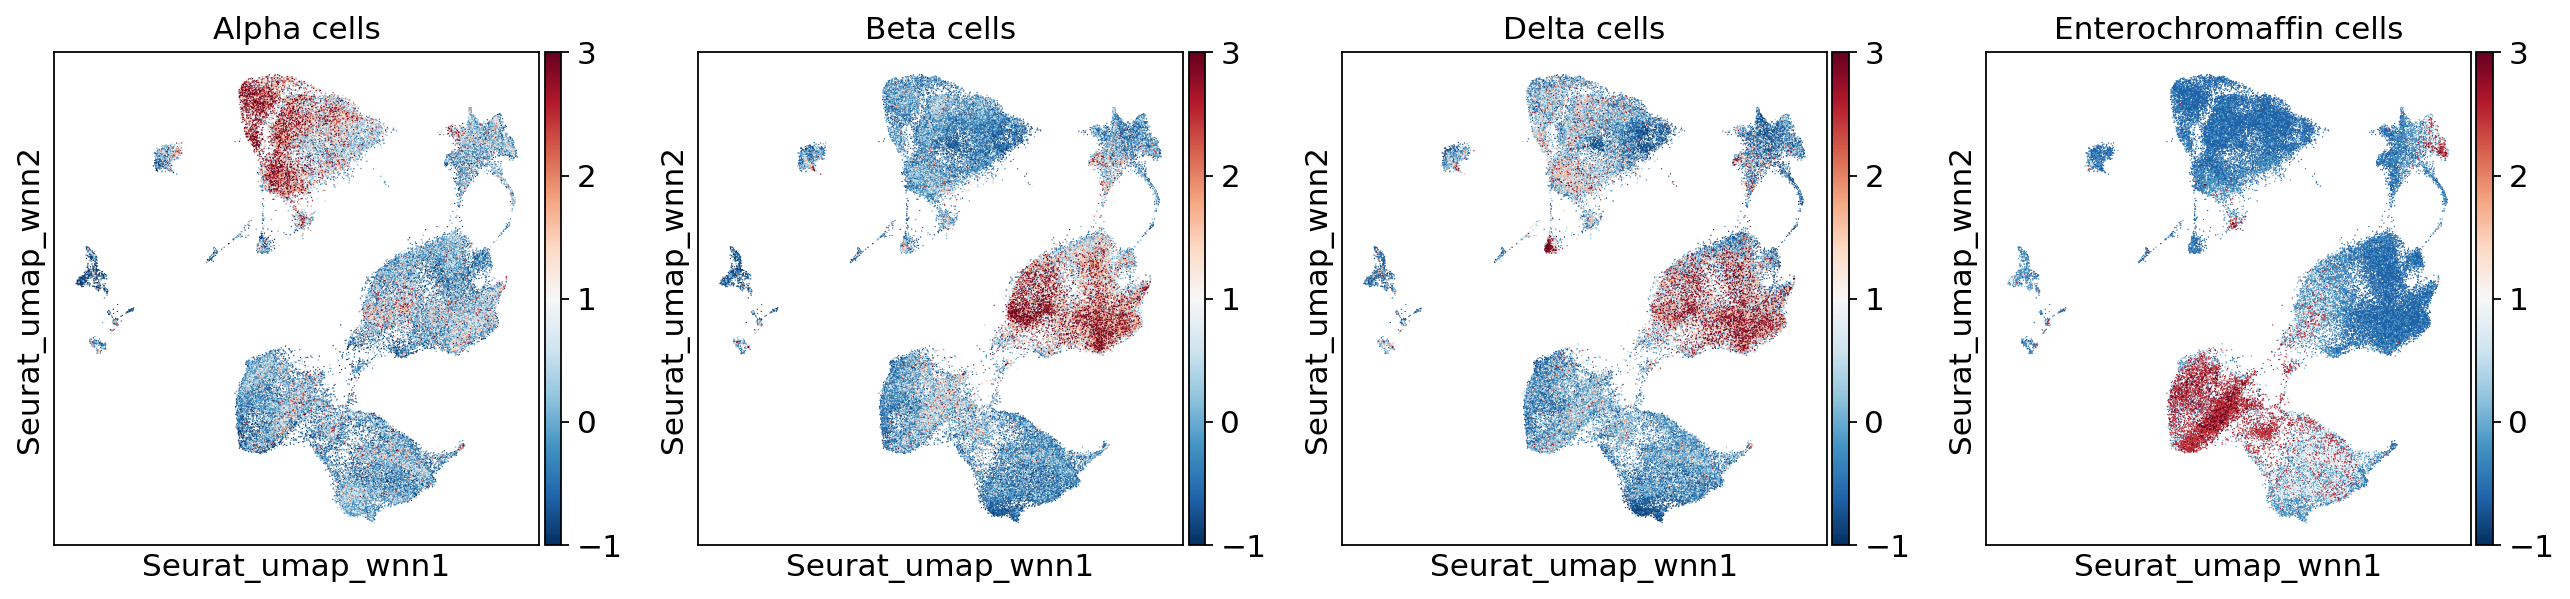

In [67]:
# Plot a few familiar cell types
with plt.rc_context():
    sc.pl.embedding(acts, basis="Seurat_umap_wnn", color=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], cmap='RdBu_r', vmin=-1, vmax=3, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_umap.png"))
    plt.show()
    plt.close()


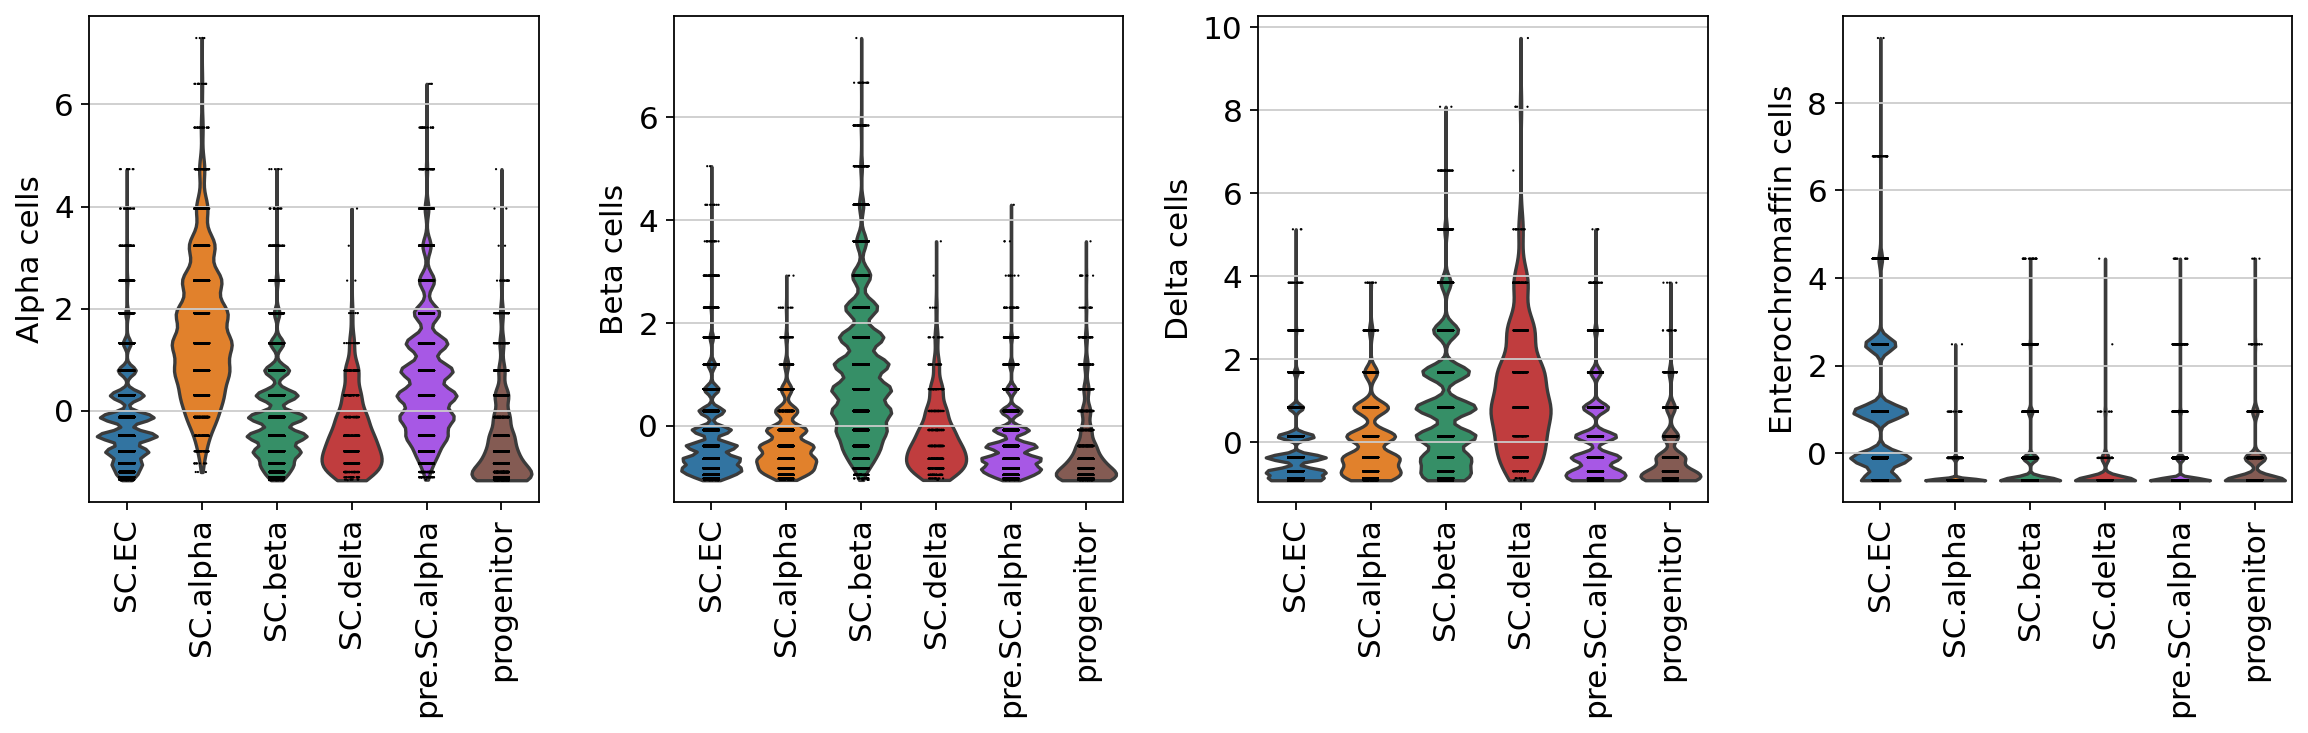

In [66]:
# Plot the violin plots
with plt.rc_context():
    sc.pl.violin(acts, keys=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], groupby='predicted.cell.type', multi_panel=True, rotation=90, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_violin.png"))
    plt.show()
    plt.close()

# Annotation
We can next find the statistically significant annotations for pre-defined groupings of interest

In [44]:
# Does just that
df = dc.rank_sources_groups(acts, groupby='predicted.cell.type', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,SC.EC,rest,Enterochromaffin cells,157.106353,1.073706,0.000000e+00,0.000000e+00
1,SC.EC,rest,Pinealocytes,83.425410,0.625961,0.000000e+00,0.000000e+00
2,SC.EC,rest,Serotonergic neurons,58.657117,0.439501,0.000000e+00,0.000000e+00
3,SC.EC,rest,Crypt cells,48.803651,0.371101,0.000000e+00,0.000000e+00
4,SC.EC,rest,Chromaffin cells,47.366987,0.358303,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
901,progenitor,rest,Chromaffin cells,-23.400669,-0.574216,3.432563e-115,4.711973e-114
902,progenitor,rest,Beta cells,-23.436583,-0.539919,6.091449e-115,7.075452e-114
903,progenitor,rest,Alpha cells,-25.764163,-0.636599,7.007408e-138,1.763531e-136
904,progenitor,rest,Neurons,-36.908815,-0.879968,4.275575e-264,3.228059e-262


In [69]:
# Save the annotation results
df.to_csv(os.path.join(out_dir, "cell_type_annotation_by_groups.tsv"), sep="\t")

In [70]:
# We can grab a dictionary of the top X for each group
n_ctypes = 5
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'SC.EC': ['Enterochromaffin cells',
  'Pinealocytes',
  'Serotonergic neurons',
  'Crypt cells',
  'Chromaffin cells'],
 'SC.alpha': ['Alpha cells',
  'Gamma (PP) cells',
  'B cells naive',
  'Interneurons',
  'Enteroendocrine cells'],
 'SC.beta': ['Beta cells',
  'Delta cells',
  'Parathyroid chief cells',
  'Choroid plexus cells',
  'Retinal ganglion cells'],
 'SC.delta': ['Neuroendocrine cells',
  'Delta cells',
  'Interneurons',
  'GABAergic neurons',
  'Cardiac stem and precursor cells'],
 'pre.SC.alpha': ['Alpha cells',
  'B cells naive',
  'Leydig cells',
  'Follicular cells',
  'B cells memory'],
 'progenitor': ['Adipocyte progenitor cells',
  'Mesangial cells',
  'Bergmann glia',
  'Embryonic stem cells',
  'Tanycytes']}

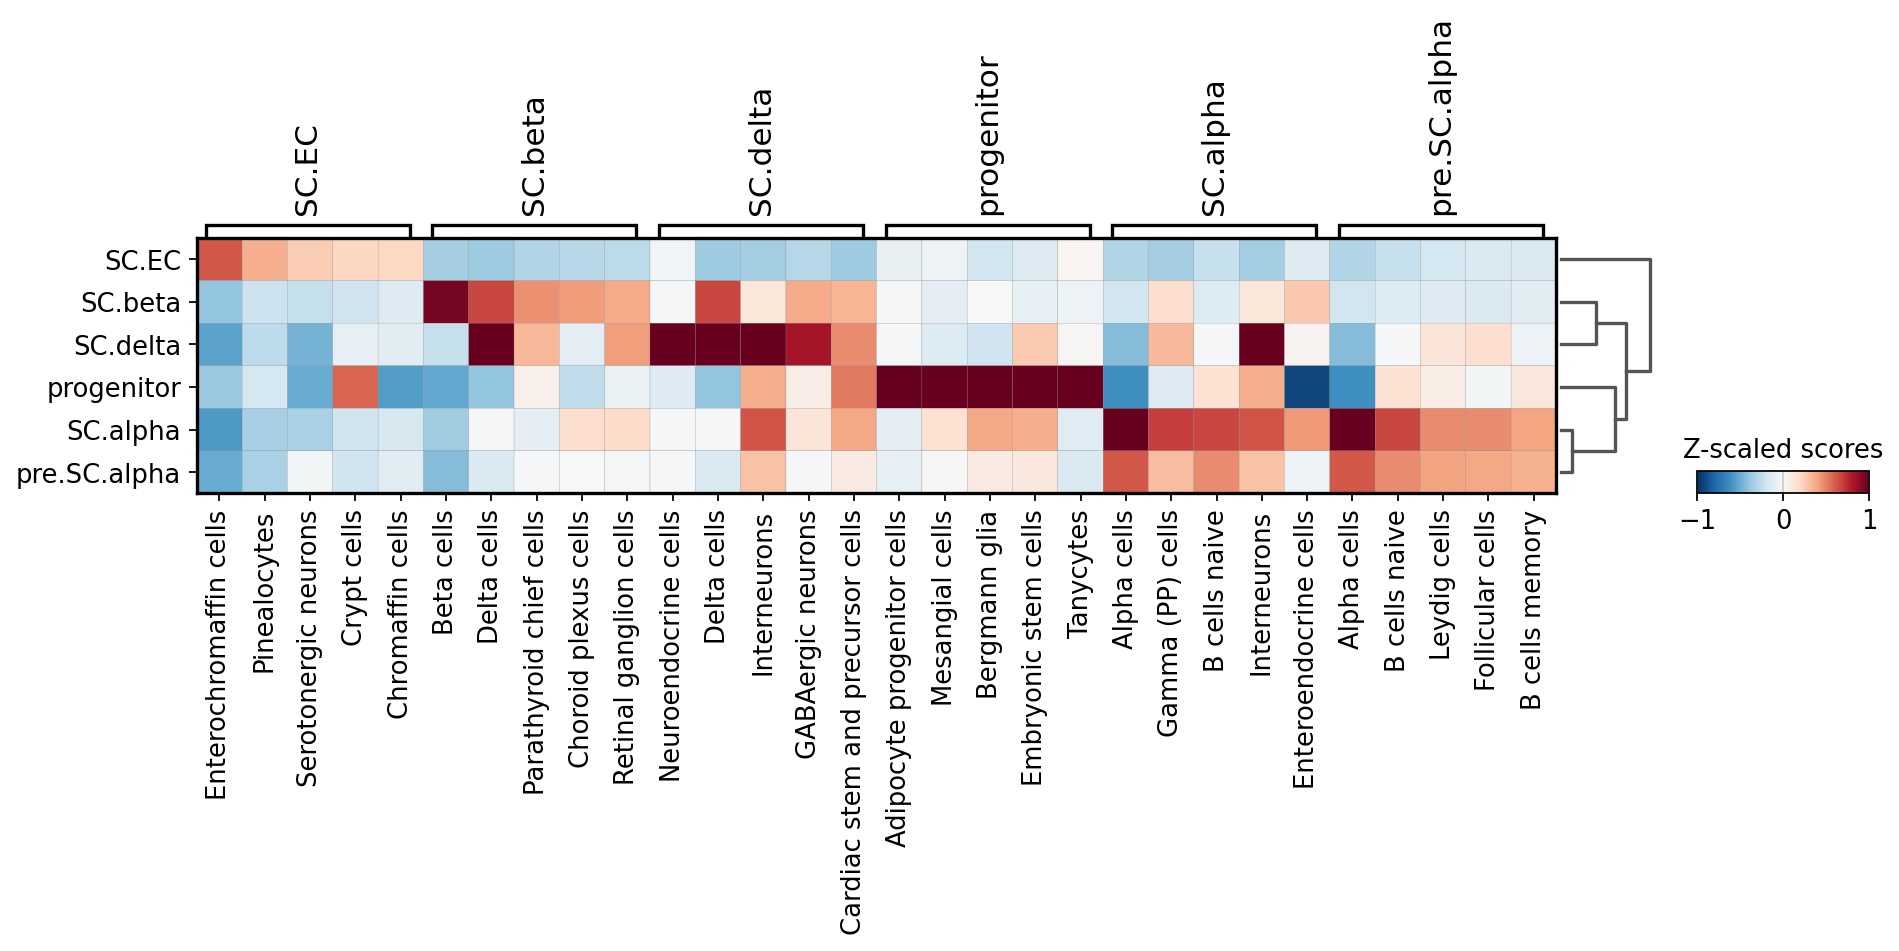

In [72]:
# And plot that as a matrixplot
with plt.rc_context():
    sc.pl.matrixplot(
        acts, 
        ctypes_dict, 
        'predicted.cell.type', 
        dendrogram=True,
        colorbar_title='Z-scaled scores', 
        vmin=-1, 
        vmax=1, 
        cmap='RdBu_r',
        show=False
    )
    plt.savefig(os.path.join(out_dir, f"{n_ctypes} cell_type_annotation_matrixplot.png"))
    plt.show()

# DONE!

---